# Example: PnL distribution of the market

## Packages

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

In [87]:
# numpy for working with matrices, etc. 
import numpy as np

# import pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter


# scipy for statistics and optimization 
from scipy import optimize
from scipy import stats

# import cvxpy
import cvxpy as cp

# function to perform interpolation
from scipy.interpolate import interp1d

"""
functions from codelib
"""

# Set plotting style
plt.rcParams['font.size'] = 14

# functions for calculating moments
import codelib.statistics.moments as mom
# functions for calculating risk metrics
import codelib.portfolio_optimization.risk_metrics as rm
# predefined plots
from codelib.visualization.base import fan_chart

In [3]:
"""
Utility functions
"""


def interpolate_weights(tau: float, tau_d: np.ndarray) -> np.ndarray:

    """
    Interpolate weights for a given tau based on the closest values in tau_d.

    Parameters
    ----------
    tau:
        Time to maturity for which weights are calculated.
    tau_d:
        Array of discrete time to maturities for which weights are defined.

    Returns
    -------
    np.ndarray
        Weights to interpolate tau based on the two closest values in tau_d.

    """

    differences = np.abs(tau_d - tau)

    # Get the indices of the two closest values
    closest_indices = np.argsort(differences)[:2]

    # Sort the indices to ensure they are in ascending order
    closest_indices = np.sort(closest_indices)

    # Get the two closest values
    x1, x2 = tau_d[closest_indices]

    # Calculate the interpolation weights
    w2 = (tau - x1) / (x2 - x1)
    w1 = 1 - w2

    # Create a weights vector (all other weights are 0)
    weights = np.zeros_like(tau_d, dtype=float)
    weights[closest_indices[0]] = w1
    weights[closest_indices[1]] = w2

    return weights

## Modelling the "market": Random walk assumption

Assume that an EUR based investor is investing in EUR and US equities and EUR and USD denominated zero coupon bonds. The market is assumed to be driven by a set of market invariants: 

$$\boldsymbol{\varepsilon}_t = \Delta \mathbf{X}_t = \begin{pmatrix} \Delta \log FX_t \\ \Delta \log V_t^{US, local} \\ \Delta \log V_t^{EUR} \\ \Delta y_t^{1/12} \\ \Delta y_t^{EUR, 1} \\ \Delta y_t^{EUR, 3} \\ \Delta y_t^{EUR, 5} \\ \Delta y_t^{EUR, 7} \\ \Delta y_t^{EUR, 10} \\ \Delta y_t^{USD, 1/12} \\ \Delta y_t^{USD, 1} \\ \Delta y_t^{USD, 3} \\ \Delta y_t^{USD, 5} \\ \Delta y_t^{USD, 7} \\ \Delta y_t^{USD, 10} \end{pmatrix}$$.

The time step is assumed to be one week or $1 / 52$ years.  $FX$ denotes the $EUR/USD$ exchange rate,  $\log V_t^{US, local}$  denotes the value of US equities measured in USD, $\log V_t^{EUR}$ is the value of EUR equities measure in EUR, $y_t^{\tau}$ is the $\tau$ year continuously compounded zero coupon yield. The whole USD and EUR yield curve is spanned by these set of zero coupon yields. The yields for any given time to maturity can be obtained by linear interpolation..

The market invariants are normally distributed

$$
\Delta \mathbf{X}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$


In [31]:
"""
Define relevant information
"""

# set seed
np.random.seed(999)

# time step
dt = 1 / 52

# horizon 
horizon = 1

# number of time steps 
num_per = int(horizon / dt)

# time points
time_points = np.arange(0, horizon + 0.0001, dt)

# number of simulations
num_sim = 10_000

# time to maturities, tau_d
tenors = np.array([1 / 12, 1.0, 3.0, 5.0, 7.0, 10.0], dtype=float)

# number of assets
num_assets = 4
num_risk_drivers = 15

# asset names
risk_driver_names = ['log FX', 'log US EQ', 'log EUR EQ', '1M EUR', '1Y EUR', '3Y EUR', '5Y EUR', '7Y EUR', '10Y EUR', 
                     '1M USD', '1Y USD', '3Y USD', '5Y USD', '7Y USD', '10Y USD']

asset_names =  ['FX', 'TRI_US_EQ_LOCAL', 'TRI_EUR_EQ', 'TRI_USD_ZCB_LOCAL', 'TRI_EUR_ZCB']

# colors
lgrey = [0.8, 0.8, 0.8]  # light grey
dgrey = [0.4, 0.4, 0.4]  # dark grey

color_list = ['navy', 'darkred', 'salmon', 'violet', 'orange']

# plotting names
plot_names = ['US EQ', 'EUR EQ', 'USD ZCB', 'EUR ZCB']

# definition of indices for risk drivers and assets
index_log_fx = 0
index_log_us_eq_in_usd = 1
index_log_eur_eq = 2
index_eur_rates = np.array([3, 4, 5, 6, 7, 8])
index_usd_rates = np.array([9, 10, 11, 12, 13, 14])

index_us_eq = 0
index_eur_eq = 1
index_usd_zcb = 2
index_eur_zcb = 3

# tenors of zero coupon
tau_now = 5
tau_hor = 4

In [7]:
"""
Load input data
"""

# expected weekly changes of risk drivers
mu_delta_x = np.array([0.0, 0.07 / 52, 0.06 / 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# covariance matrix of weekly changes
df_cov_mat_delta_x = pd.read_excel('covariance_matrix.xlsx', index_col=0)
cov_mat_delta_x = df_cov_mat_delta_x.values

# volatilities 
vols_delta_x = np.sqrt(np.diag(cov_mat_delta_x))

# initial values of risk drivers
df_init_values = pd.read_excel('init_values.xlsx', index_col=0)
init_x = df_init_values.values.flatten()

### The distribution of risk drivers after $N$ periods 

Since the changes are assumed to be i.i.d. normally distributed 

$$
\Delta \mathbf{X}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

then it directly follows that the risk drivers are normally distributed at the horizon with

$$
\mathbf{X}_{0 + N \cdot \Delta t} \sim N(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)
$$

with $\boldsymbol{\mu}_1 = \mathbf{x}_0 + \boldsymbol{\mu} \cdot N$ and $\boldsymbol{\Sigma}_1 = \boldsymbol{\Sigma} \cdot N$. 

### Simulate dynamics of risk drivers for the next 1Y with weekly time steps

In [8]:
"""
Define function to simulate risk drivers
"""

def sim_risk_drivers(initial_values: np.ndarray,
                    mu: np.ndarray,
                    cov_mat: np.ndarray,
                    num_sim: int,
                    num_per: int):
    
    # number of risk drivers
    num_risk_drivers = len(mu)
    
    # define matrix to store values
    risk_drivers = np.zeros((num_sim, 1 + num_per, num_risk_drivers))
    risk_drivers[:, 0, :] = initial_values
    
    # simulate normal invariants
    eps = stats.multivariate_normal(mean=mu, cov=cov_mat).rvs(size=(num_sim, num_per))
    
    # create risk drives at horizon
    risk_drivers[:, 1:, :] = initial_values + np.cumsum(eps, axis=1)
    
    return risk_drivers

In [9]:
"""
Simulate risk drivers
"""

# dictionary for storing simulated data
sim_data = dict()

# simulate risk drivers
risk_drivers = sim_risk_drivers(init_x, mu_delta_x, cov_mat_delta_x, num_sim, num_per)

# store data 
sim_data['LOG_FX'] = risk_drivers[:, :, index_log_fx]
sim_data['LOG_US_EQ_LOCAL'] = risk_drivers[:, :, index_log_us_eq_in_usd]
sim_data['LOG_EUR_EQ'] = risk_drivers[:, :, index_log_eur_eq]

for i, name in zip(index_eur_rates, ['1M', '1Y', '3Y', '5Y', '7Y', '10Y']):
    sim_data['EUR_RATE_' + name] = risk_drivers[:, :, i]

for i, name in zip(index_usd_rates, ['1M', '1Y', '3Y', '5Y', '7Y', '10Y']):
    sim_data['USD_RATE_' + name] = risk_drivers[:, :, i]

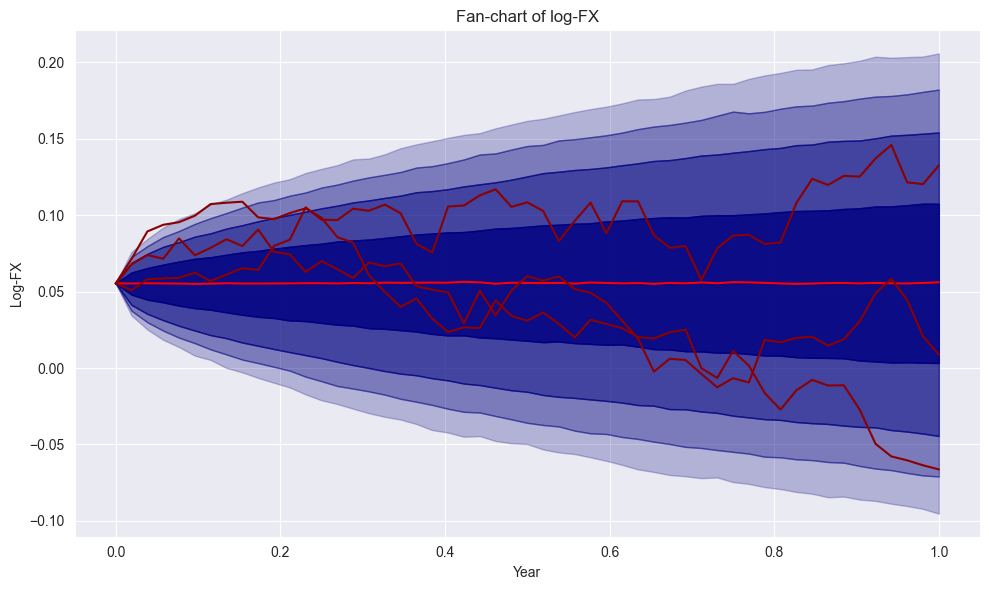

In [15]:
# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data['LOG_FX'], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

# plot some simulated paths
ax.plot(time_points, sim_data['LOG_FX'][20, :], color="darkred")
ax.plot(time_points, sim_data['LOG_FX'][499, :], color="darkred")
ax.plot(time_points, sim_data['LOG_FX'][999, :], color="darkred")

# set labels and legends
ax.set(ylabel="Log-FX", xlabel="Year", title="Fan-chart of log-FX");

# savefig
plt.tight_layout()
plt.savefig('fanchart_log_fx_evolution_week2.png', dpi=300)


## Simulate price evolution

In [18]:
"""
Evolution of equities + FX
"""

sim_data['TRI_US_EQ_LOCAL'] = np.exp(sim_data['LOG_US_EQ_LOCAL'])
sim_data['TRI_EUR_EQ'] = np.exp(sim_data['LOG_EUR_EQ'])
sim_data['FX'] = np.exp(sim_data['LOG_FX'])

"""
Simulate evolution of bond prices
"""

sim_data['TRI_USD_ZCB_LOCAL'] = np.zeros_like(sim_data['LOG_FX'])
sim_data['TRI_EUR_ZCB'] = np.zeros_like(sim_data['LOG_FX'])

init_ttm = 5.0
sim_data['TRI_USD_ZCB_LOCAL'][:, 0] = np.exp(-init_ttm * sim_data['USD_RATE_5Y'][:, 0])
sim_data['TRI_EUR_ZCB'][:, 0] = np.exp(-init_ttm * sim_data['EUR_RATE_5Y'][:, 0])


for i in range(1, num_per + 1):

    current_ttm = init_ttm - dt * i
    b_vec = interpolate_weights(current_ttm, tenors)

    sim_data['TRI_USD_ZCB_LOCAL'][:, i] = np.exp(-current_ttm * risk_drivers[:, i, index_usd_rates] @ b_vec)
    sim_data['TRI_EUR_ZCB'][:, i] = np.exp(-current_ttm * risk_drivers[:, i, index_eur_rates] @ b_vec)


"""
Simulate prices of US assets in EUR
"""


sim_data['TRI_US_EQ'] = sim_data['TRI_US_EQ_LOCAL'] / sim_data['FX']
sim_data['TRI_USD_ZCB'] = sim_data['TRI_USD_ZCB_LOCAL'] / sim_data['FX']
sim_data['FX_INV'] = 1.0 / sim_data['FX']

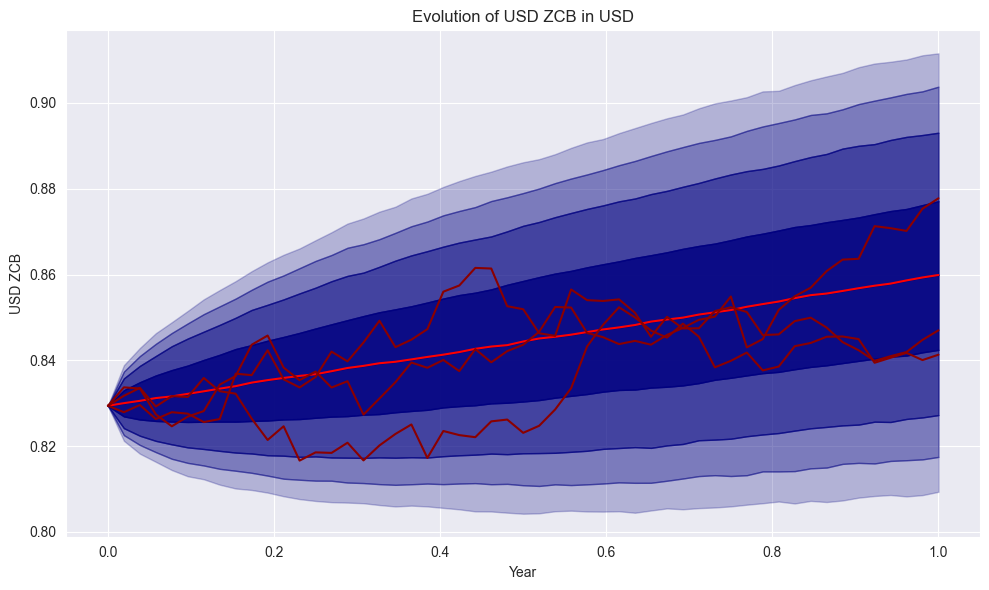

In [24]:
# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data['TRI_USD_ZCB_LOCAL'], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

# plot some simulated paths
ax.plot(time_points, sim_data['TRI_USD_ZCB_LOCAL'][20, :], color="darkred")
ax.plot(time_points, sim_data['TRI_USD_ZCB_LOCAL'][499, :], color="darkred")
ax.plot(time_points, sim_data['TRI_USD_ZCB_LOCAL'][999, :], color="darkred")

# set labels and legends
ax.set(ylabel=plot_names[index_usd_zcb], xlabel="Year", title="Evolution of {} in USD".format(plot_names[index_usd_zcb]))

# savefig
plt.tight_layout()
plt.savefig('fanchart_us_bond_in_usd.png', dpi=300)

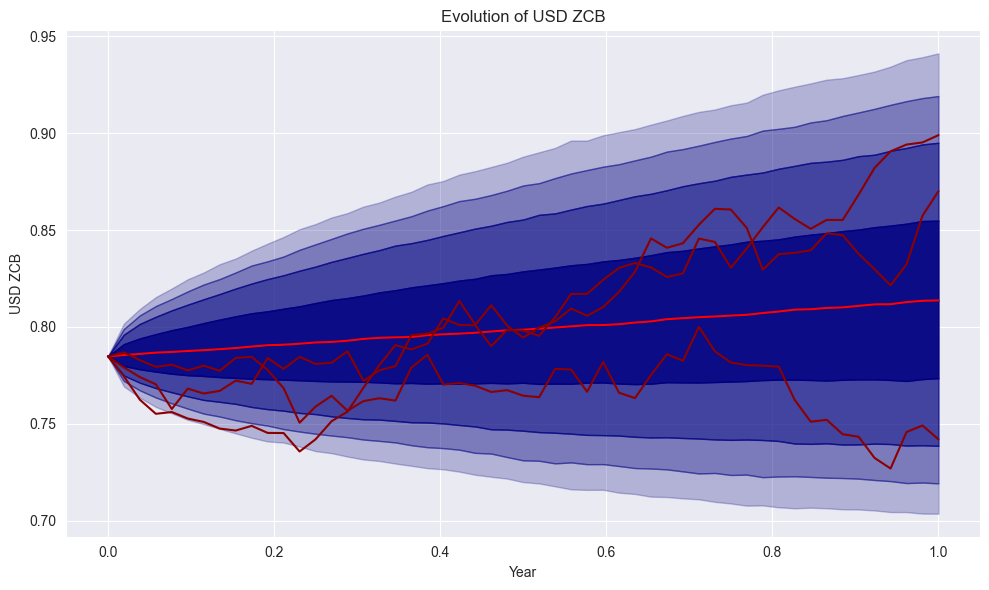

In [27]:
# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data['TRI_USD_ZCB'], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

# plot some simulated paths
ax.plot(time_points, sim_data['TRI_USD_ZCB'][20, :], color="darkred")
ax.plot(time_points, sim_data['TRI_USD_ZCB'][499, :], color="darkred")
ax.plot(time_points, sim_data['TRI_USD_ZCB'][999, :], color="darkred")

# set labels and legends
ax.set(ylabel=plot_names[index_usd_zcb], xlabel="Year", title="Evolution of {}".format(plot_names[index_usd_zcb]))

# savefig
plt.tight_layout()
plt.savefig('fanchart_us_bond_in_eur.png', dpi=300)

## Exact distribution

In [41]:
"""
Distribution of risk drives at the horizon
"""

mu_x_t_hor = init_x + num_per * mu_delta_x  # expected value of risk drivers at horizon
cov_mat_x_t_hor = num_per * cov_mat_delta_x  # covariance matrix of risk drivers at horizon


"""
Initial prices of cash assets
"""

# initialize linear transformation matrix a
a = np.zeros((num_assets, num_risk_drivers))

# US equities in EUR
a[index_us_eq, index_log_us_eq_in_usd] = 1
a[index_us_eq, index_log_fx] = -1

# EUR equities in EUR
a[index_eur_eq, index_log_eur_eq] = 1

# USD zero coupon bonds in EUR
a[index_usd_zcb, index_usd_rates] = -tau_now * interpolate_weights(tau_now, tenors)
a[index_usd_zcb, index_log_fx] = -1

# EUR zero coupon bonds in EUR
a[index_eur_zcb, index_eur_rates] = -tau_now * interpolate_weights(tau_now, tenors)

# initial prices of cash assets and forward price
z_t_now = np.exp(a @ init_x)

In [71]:
"""
Distribution of asset prices and currency at the horizon
"""

# initialize linear transformation matrix b
b = np.zeros((num_assets, num_risk_drivers))

# US equities in EUR at horizon
b[index_us_eq, index_log_us_eq_in_usd] = 1
b[index_us_eq, index_log_fx] = -1

# EUR equities in EUR at horizon
b[index_eur_eq, index_log_eur_eq] = 1

# USD zero coupon bonds in EUR at horizon
b[index_usd_zcb, index_usd_rates] = -tau_hor * interpolate_weights(tau_hor, tenors)
b[index_usd_zcb, index_log_fx] = -1

# EUR zero coupon bonds in EUR at horizon
b[index_eur_zcb, index_eur_rates] = -tau_hor * interpolate_weights(tau_hor, tenors)

# parameters for the shifted log-normal distribution at the horizon
mu_log_v_t_hor = b @ mu_x_t_hor
cov_mat_log_v_t_hor = b @ cov_mat_x_t_hor @ b.T
vol_log_v_t_hor = np.sqrt(np.diag(cov_mat_log_v_t_hor))

"""
ex-ante pnl distribution and moments
"""

# calculate the expected value and covariance matrix of the ex-ante profit and loss at the horizon
mu_delta_pi = np.exp(mu_log_v_t_hor + 0.5 * np.diag(cov_mat_log_v_t_hor).T) - v_t_now
cov_mat_delta_pi = np.diag((mu_delta_pi + v_t_now).flatten()) @ (np.exp(cov_mat_log_v_t_hor) - np.ones((num_assets, num_assets))) @ np.diag((mu_delta_pi + v_t_now).flatten())

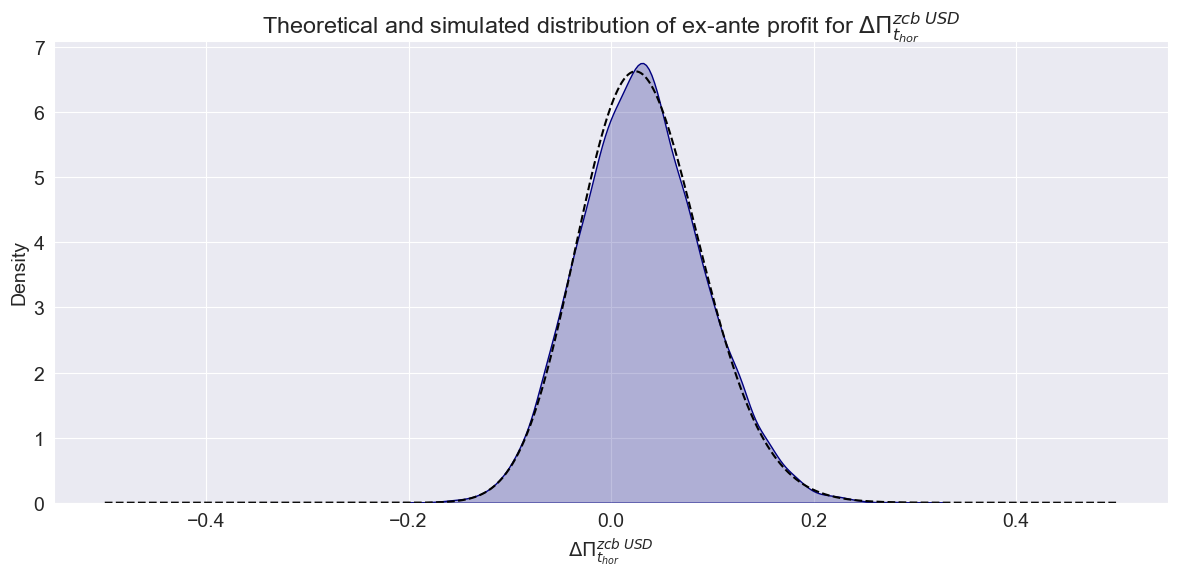

In [88]:
"""
Example - ex-ante pnl distribution USD ZCB
"""

# select asset index for USD ZCB
asset_index = 2
asset = 'TRI_USD_ZCB'

# Calculate the theoretical distribution of the ex-ante profit and loss for USD ZCB
dist = stats.lognorm(s=vol_log_v_t_hor[asset_index],
               scale=np.exp(mu_log_v_t_hor[asset_index]),
               loc=-v_t_now[asset_index])

# x-values for plotting the theoretical distribution
x_vals = np.linspace(-0.5, 0.5, 1000)

# Plot figure
fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density based on simulations
sns.kdeplot(sim_data[asset][:, -1] - v_t_now[asset_index], fill=True, color="navy", ax=ax)

# True pdf
ax.plot(x_vals, dist.pdf(x_vals), color="black", linestyle="--")

ax.set_xlabel('$\\Delta \\Pi_{t_{hor}}^{zcb \\; USD}$')
ax.set_title('Theoretical and simulated distribution of ex-ante profit for $\\Delta \\Pi_{t_{hor}}^{zcb \\; USD}$')

plt.tight_layout()
plt.savefig('ex_ante_pnl_usd_zcb.pdf', dpi=300)